In [1]:
import os 
import tensorflow as tf 
import numpy as np 
import seaborn as sns 
import pathlib 
from IPython import display 
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report

In [2]:
import sys
print(sys.executable)


C:\Anaconda\python.exe


In [3]:
os.listdir('data2')

['a',
 'about',
 'am',
 'and',
 'any',
 'are',
 'at',
 'can',
 'cost',
 'day',
 'do',
 'does',
 'english',
 'fine',
 'food',
 'get',
 'have',
 'help',
 'how',
 'i',
 'is',
 'it',
 'long',
 'man',
 'much',
 'name',
 'nearest',
 'of',
 'please',
 'recommendations',
 'restroom',
 'say',
 'see',
 'take',
 'that',
 'the',
 'this',
 'time',
 'to',
 'what',
 'where',
 'will',
 'you']

In [4]:
# Using audio_dataset_from_directory function to create dataset with audio data 
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory( 
	directory='data2', 
	batch_size=4, 
	validation_split=0.1, 
    output_sequence_length=None,
	#output_sequence_length=16000,
	seed=0, 
	subset='both') 

# Extracting audio labels 
label_names = np.array(training_set.class_names)
print("label names:", label_names)

Found 25800 files belonging to 43 classes.
Using 23220 files for training.
Using 2580 files for validation.
label names: ['a' 'about' 'am' 'and' 'any' 'are' 'at' 'can' 'cost' 'day' 'do' 'does'
 'english' 'fine' 'food' 'get' 'have' 'help' 'how' 'i' 'is' 'it' 'long'
 'man' 'much' 'name' 'nearest' 'of' 'please' 'recommendations' 'restroom'
 'say' 'see' 'take' 'that' 'the' 'this' 'time' 'to' 'what' 'where' 'will'
 'you']


In [5]:
# Defining the squeeze function 
def squeeze(audio, labels): 
    audio = tf.squeeze(audio, axis=-1) 
    return audio, labels 
    

# Applying the function on the dataset obtained from previous step 
training_set = training_set.map(squeeze, tf.data.AUTOTUNE) 
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [6]:
# Visualize the waveform 
audio, label = next(iter(training_set)) 
display.display(display.Audio(audio[1], rate=16000))

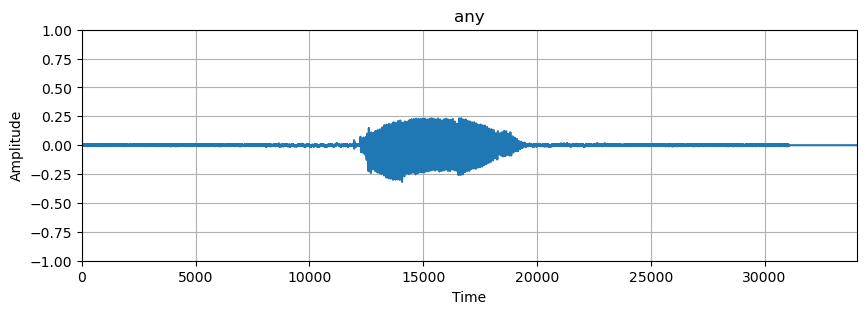

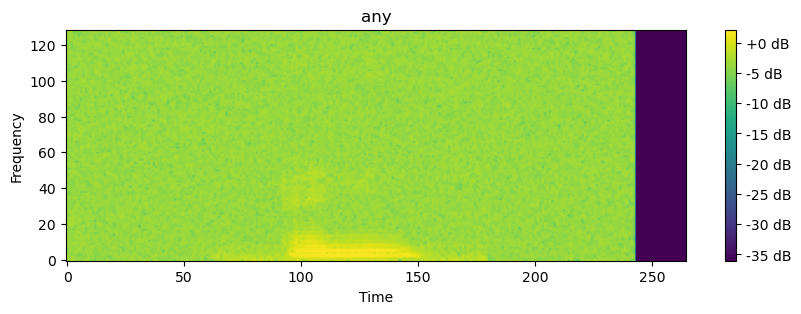

In [7]:
# Plot the waveform
def plot_wave(waveform, label):
    plt.figure(figsize=(10, 3))
    plt.title(label)
    plt.plot(waveform)
    plt.xlim([0, len(waveform)])  # Dynamically set xlim based on the length of the waveform
    plt.ylim([-1, 1])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)

# Convert waveform to spectrogram
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram[..., tf.newaxis]

# Plot the spectrogram
def plot_spectrogram(spectrogram, label):
    spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    plt.figure(figsize=(10, 3))
    plt.title(label)
    plt.imshow(log_spec, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Plotting the waveform and the spectrogram of a random sample
audio, label = next(iter(training_set))

# Ensure the label is correctly indexed if label[0] is not an index directly
plot_wave(audio[0], label_names[label[0]])

# Plot the spectrogram with its label name
plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])


In [8]:
# Creating spectrogram dataset from waveform or audio data 
def get_spectrogram_dataset(dataset): 
	dataset = dataset.map( 
		lambda x, y: (get_spectrogram(x), y), 
		num_parallel_calls=tf.data.AUTOTUNE) 
	return dataset 

# Applying the function on the audio dataset 
train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 

# Dividing validation set into two equal val and test set 
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)


In [9]:
#Check dimention of input data
train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 

print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, None, 129, 1)
Validation set shape: (None, None, 129, 1)
Testing set shape: (None, None, 129, 1)


In [10]:
# Defining the model 
def get_model(input_shape, num_labels): 
	model = tf.keras.Sequential([ 
		tf.keras.layers.Input(shape=input_shape), 
		# Resizing the input to a square image of size 64 x 64 and normalizing it 
		tf.keras.layers.Resizing(64, 64), 
		tf.keras.layers.Normalization(), 
		
		# Convolution layers followed by MaxPooling layer 
		tf.keras.layers.Conv2D(64, 3, activation='relu'), 
		tf.keras.layers.Conv2D(128, 3, activation='relu'), 
		tf.keras.layers.MaxPooling2D(), 
		tf.keras.layers.Dropout(0.5), 
		tf.keras.layers.Flatten(), 
		
		# Dense layer 
		tf.keras.layers.Dense(256, activation='relu'), 
		tf.keras.layers.Dropout(0.1), 
		
		# Softmax layer to get the label prediction 
		tf.keras.layers.Dense(num_labels, activation='softmax') 
	]) 
	# Printing model summary 
	model.summary() 
	return model 

# Getting input shape from the sample audio and number of classes 
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names) 

# Creating a model 
model = get_model(input_shape, num_labels)

Input shape: (265, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,577,006 (112.83 MB)

 Trainable params: 29,577,003 (112.83 MB)

 Non-trainable params: 3 (16.00 B)

In [21]:
model.compile( 
	optimizer=tf.keras.optimizers.Adam(), 
	loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
	metrics=['accuracy'], 
) 

EPOCHS = 7
history = model.fit( 
	train_set, 
	validation_data=val_set, 
	epochs=EPOCHS, 
)


Epoch 1/7
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1987s 342ms/step - accuracy: 0.3981 - loss: 2.1573 - val_accuracy: 0.8447 - val_loss: 0.4753
Epoch 2/7
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1765s 304ms/step - accuracy: 0.7779 - loss: 0.6736 - val_accuracy: 0.9115 - val_loss: 0.3089
Epoch 3/7
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1768s 305ms/step - accuracy: 0.8421 - loss: 0.4907 - val_accuracy: 0.9255 - val_loss: 0.2404
Epoch 4/7
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1793s 309ms/step - accuracy: 0.8717 - loss: 0.3909 - val_accuracy: 0.9317 - val_loss: 0.1890
Epoch 5/7
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1796s 309ms/step - accuracy: 0.8895 - loss: 0.3436 - val_accuracy: 0.9488 - val_loss: 0.1567
Epoch 6/7
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1796s 309ms/step - accuracy: 0.9066 - loss: 0.3010 - val_accuracy: 0.9495 - val_loss: 0.1477
Epoch 7/7
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1781s 307ms/step - accuracy: 0.9131 - loss: 0.2697 - val_accuracy: 0.9526 - val_loss: 0.1473


In [23]:
#Save Model
model.save('my_model.keras')
print("Model Saved Succcessfully")

Model Saved Succcessfully


In [31]:
model.compile( 
	optimizer=tf.keras.optimizers.Adam(), 
	loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
	metrics=['accuracy'], 
) 

EPOCHS = 3
history = model.fit( 
	train_set, 
	validation_data=val_set, 
	epochs=EPOCHS, 
)


Epoch 1/3
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1771s 305ms/step - accuracy: 0.9246 - loss: 0.2449 - val_accuracy: 0.9666 - val_loss: 0.1180
Epoch 2/3
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1775s 306ms/step - accuracy: 0.9206 - loss: 0.2407 - val_accuracy: 0.9682 - val_loss: 0.1022
Epoch 3/3
5805/5805 ━━━━━━━━━━━━━━━━━━━━ 1775s 306ms/step - accuracy: 0.9353 - loss: 0.2160 - val_accuracy: 0.9720 - val_loss: 0.1038


In [35]:
#Save Model
model.save('my_model2.keras')
print("Model Saved Succcessfully")

Model Saved Succcessfully


In [37]:
print(history.epoch)


[0, 1, 2]


Text(0, 0.5, 'Accuracy')

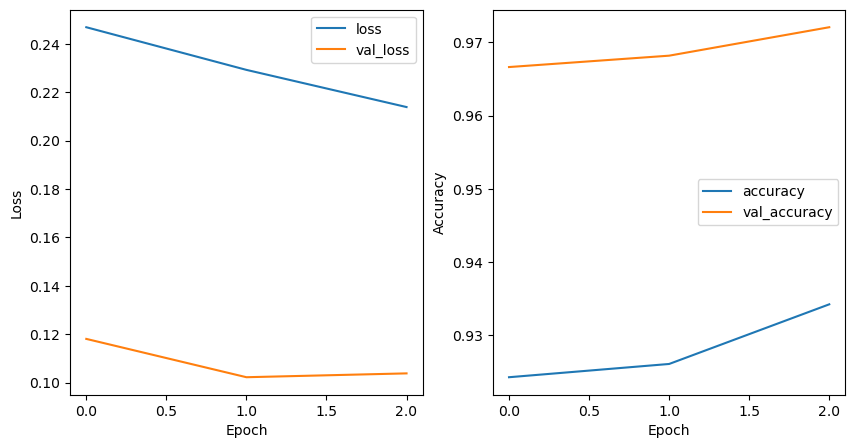

In [39]:
# Plotting validation and training loss and accuracy.
# Plotting the history 
metrics = history.history 
plt.figure(figsize=(10, 5)) 

# Plotting training and validation loss 
plt.subplot(1, 2, 1) 
plt.plot(history.epoch, metrics['loss'], metrics['val_loss']) 
plt.legend(['loss', 'val_loss']) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 

# Plotting training and validation accuracy 
plt.subplot(1, 2, 2) 
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy']) 
plt.legend(['accuracy', 'val_accuracy']) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


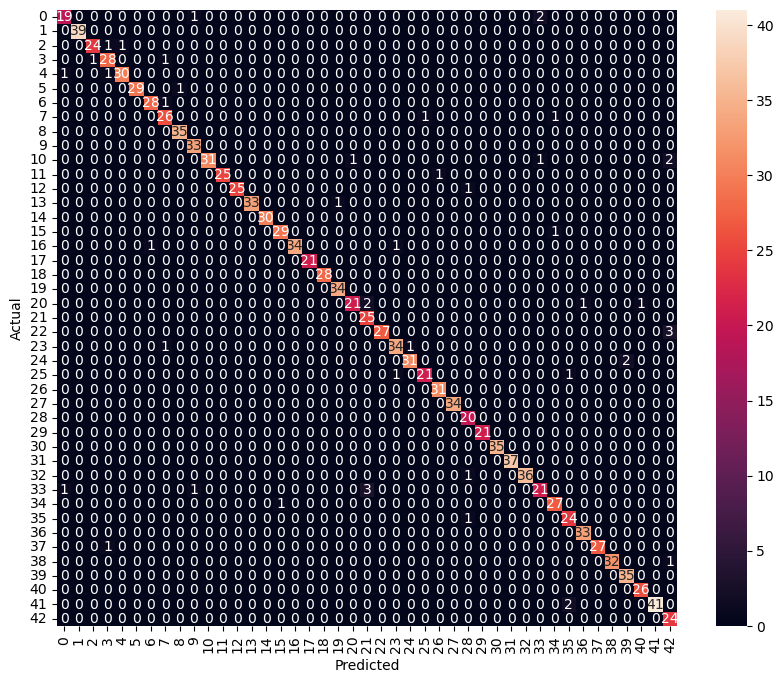

In [41]:
# Confusion matrix 
y_pred = np.argmax(model.predict(test_set), axis=1) 
y_true = np.concatenate([y for x, y in test_set], axis=0) 
cm = tf.math.confusion_matrix(y_true, y_pred) 

# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

In [45]:
report = classification_report(y_true, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       1.00      1.00      1.00        39
           2       0.96      0.92      0.94        26
           3       0.90      0.93      0.92        30
           4       0.97      0.94      0.95        32
           5       1.00      0.97      0.98        30
           6       0.97      0.97      0.97        29
           7       0.90      0.93      0.91        28
           8       0.97      1.00      0.99        35
           9       0.94      1.00      0.97        33
          10       1.00      0.89      0.94        35
          11       1.00      0.96      0.98        26
          12       1.00      0.96      0.98        26
          13       1.00      0.97      0.99        34
          14       1.00      1.00      1.00        30
          15       0.97      0.97      0.97        30
          16       1.00      0.94      0.97        36
          17       1.00    

In [20]:
model = tf.keras.models.load_model('my_model.keras')

Processing file: ./mono_test_data/a\a2.wav


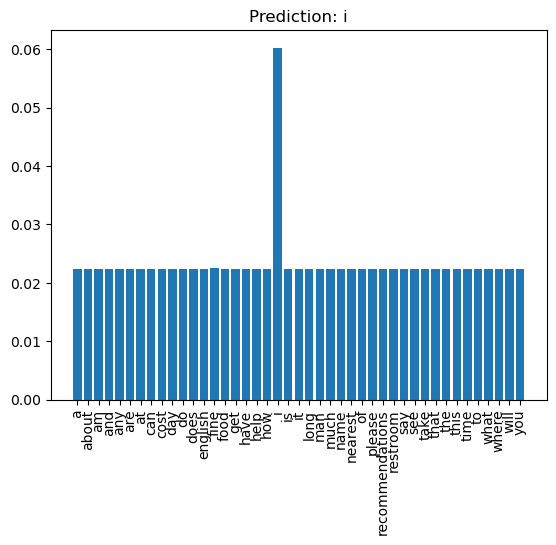

Predicted label for ./mono_test_data/a\a2.wav: i
Processing file: ./mono_test_data/a\a3.wav


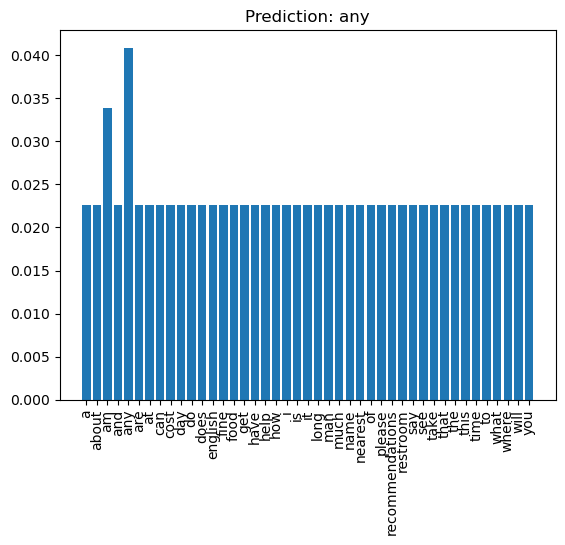

Predicted label for ./mono_test_data/a\a3.wav: any
Processing file: ./mono_test_data/a\a4.wav


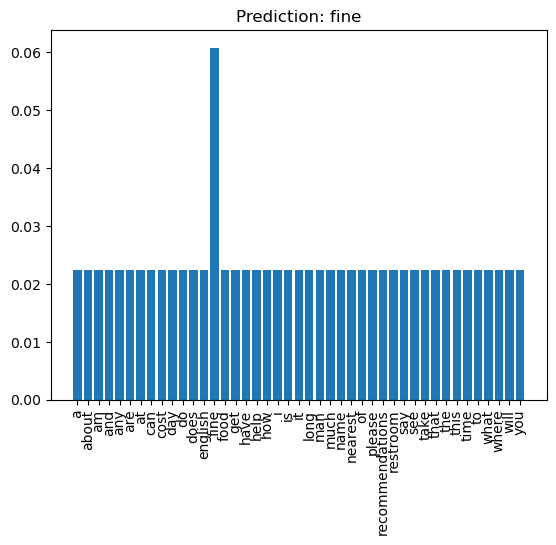

Predicted label for ./mono_test_data/a\a4.wav: fine


In [22]:
def process_audio_file(path, model, label_names):
    folder_name = os.path.basename(os.path.dirname(path))
    Input = tf.io.read_file(str(path))
    x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1)

    audio, labels = squeeze(x, folder_name)

    waveform = audio
    display.display(display.Audio(waveform, rate=16000))

    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # Adding a batch dimension

    # Make the prediction
    prediction = model(spectrogram)
    prediction_softmax = tf.nn.softmax(prediction[0])

    # Determine the predicted label
    predicted_label_index = np.argmax(prediction, axis=1).item()
    predicted_label = label_names[predicted_label_index]

    # Plot prediction probabilities
    plt.bar(label_names, prediction_softmax)
    plt.title('Prediction: ' + predicted_label)
    plt.xticks(rotation=90)
    plt.show()

    return predicted_label

def process_audio_folder(folder_path, model, label_names):
    audio_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]

    for audio_file in audio_files:
        print(f'Processing file: {audio_file}')
        predicted_label = process_audio_file(audio_file, model, label_names)
        print(f'Predicted label for {audio_file}: {predicted_label}')

# Example usage
folder_path = './mono_test_data/a'  # Replace with your folder path
process_audio_folder(folder_path, model, label_names)

In [55]:
import os
import numpy as np
import tensorflow as tf

def check_audio_energy(path, threshold=1e-5, silence_samples=0.01):
    """
    Check the energy of the audio file to determine if it's silent or contains voice.
    
    Args:
    - path (str): Path to the audio file.
    - threshold (float): The energy level below which the audio is considered silent.
    - silence_samples (float): Time (in seconds) to check for silence over; if the max amplitude
      is below threshold for this duration, the audio is considered silent.
    
    Returns:
    - tuple: (bool, float) - True if the audio contains voice (above the threshold), 
      False if it's silent, and the maximum amplitude value.
    """
    # Read the audio file
    Input = tf.io.read_file(str(path))
    x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1)

    # Flatten the audio tensor to 1D
    audio_flat = tf.squeeze(x)

    # Get the maximum amplitude
    max_amplitude = tf.reduce_max(tf.abs(audio_flat))

    # Return whether the audio contains voice or is silent and the max amplitude
    return max_amplitude > threshold, max_amplitude.numpy()  # Convert tensor to numpy float

def process_audio_folder_for_silence(folder_path, threshold=1e-5):
    """
    Process all .wav files in the folder to check for silence.
    
    Args:
    - folder_path (str): Path to the folder containing .wav files.
    - threshold (float): Amplitude threshold below which the audio is considered silent.
    
    Prints:
    - Whether each audio file is silent or contains voice along with its maximum amplitude.
    """
    # Get list of all .wav files in the folder
    audio_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]

    # Loop through each audio file and check if it's silent
    for audio_file in audio_files:
        is_voice, max_amplitude = check_audio_energy(audio_file, threshold)
        if is_voice:
            print(f"Voice detected in file: {audio_file} | Max Amplitude: {max_amplitude:.6f}")
        else:
            print(f"Silence detected in file: {audio_file} | Max Amplitude: {max_amplitude:.6f}")

# Example usage
folder_path = 'mono_test_data2/e'  # Replace with your folder path
process_audio_folder_for_silence(folder_path, threshold=0.1)



Silence detected in file: mono_test_data2/e\e1.wav | Max Amplitude: 0.076324
Voice detected in file: mono_test_data2/e\e2.wav | Max Amplitude: 0.290436
Voice detected in file: mono_test_data2/e\e3.wav | Max Amplitude: 0.210815
Voice detected in file: mono_test_data2/e\e4.wav | Max Amplitude: 0.363678
Voice detected in file: mono_test_data2/e\e5.wav | Max Amplitude: 0.208160
